# 1. Loading Data

In [1]:
import sys
import gc
import os
import warnings
import pickle
import statsmodels.api as sm
from pylab import rcParams
import time
from  datetime import datetime, timedelta

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

register_matplotlib_converters()
sns.set()

/usr/local/anaconda3/envs/data_science/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


## 1.1 Functions

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def display_missing(df):    
    for col in df.columns.tolist():  
        if df[col].isnull().sum() != 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    


## 1.2 Loading data grid

In [3]:
DATA_GRID_INPUT_DIR = '.'

In [4]:
print('Loading the data...')

data = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data_model2.pkl')

Loading the data...


## 1.3 Init variables

In [5]:
h = 28 # Prediction horizon
max_lags = 65 # Max lags used
TRAINING_LAST_DAY_NUM = 1913 # Last day for training data
FIRST_PRED_DAY = datetime(2016,4, 25) # First prediction day
FIRST_LOADING_DAY = datetime(2013, 4,7) # First day for training
FIRST_LOADING_DAY_NUM = 800
SEED = 7


## 1.4 Cuting the dataset

In [6]:
# Determine first needed day for training
# data = data.loc[data['date'] >= FIRST_LOADING_DAY] # So we will have space for lag and rolling features
# gc.collect()
# data.shape

# 2. Feature Engineering

## Creating features


In [7]:
def create_features(df):
    lags = [7, 28]
    lag_cols = [f"lag_t{lag}" for lag in lags ]

    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","sales"]].groupby("id")["sales"].shift(lag).astype(np.float16)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df[f"rmean_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).astype(np.float16)
               
    # Adding lagged and rolling features
#     df_grpby_id_sales = df[["id","sales"]].groupby(["id"])["sales"]
#     for val in [1, 2, 3, 4, 5, 6, 7, 28]:
#         df[f"lag_t{val}"] = df_grpby_id_sales.shift(val).astype(np.float16)

#     SHIFT_DAYS = 1 # So we make this features starting from previous day
#     for val in [7, 14, 28]:
#         df[f"rolling_mean_t{val}"] = df_grpby_id_sales.transform(lambda x: x.shift(SHIFT_DAYS).rolling(val).mean()).astype(np.float16)
#         df[f"rolling_std_t{val}"] = df_grpby_id_sales.transform(lambda x: x.shift(SHIFT_DAYS).rolling(val).std()).astype(np.float16)        
#         df[f"rolling_max_t{val}"] = df_grpby_id_sales.transform(lambda x: x.shift(SHIFT_DAYS).rolling(val).max()).astype(np.float16)

    # Adding price related features
#     PRICE_WINDOW = 60
#     df_grpby_id_sell_price = df[['id','sell_price']].groupby(["id"])["sell_price"]
#     df['price_max_t60'] = df_grpby_id_sell_price.transform(lambda x: x.rolling(PRICE_WINDOW).max()).astype(np.float16)
#     df['price_min_t60'] = df_grpby_id_sell_price.transform(lambda x: x.rolling(PRICE_WINDOW).min()).astype(np.float16)
#     df['price_std_t60'] = df_grpby_id_sell_price.transform(lambda x: x.rolling(PRICE_WINDOW).std()).astype(np.float16)
#     df['price_mean_t60'] = df_grpby_id_sell_price.transform(lambda x: x.rolling(PRICE_WINDOW).mean()).astype(np.float16)

#     df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)
    df['price_mean_t60'] = df[['id','sell_price']].groupby(["id"])["sell_price"].transform(lambda x: x.rolling(60).mean()).astype(np.float16)
    df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)
    
    date_features = {
        
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     df.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(df["date"].dt, date_feat_func).astype("int16")
    

In [8]:
%%time

create_features(data)

CPU times: user 2min 37s, sys: 7.18 s, total: 2min 44s
Wall time: 2min 54s


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40718219 entries, 0 to 40718218
Data columns (total 33 columns):
 #   Column              Dtype         
---  ------              -----         
 0   id                  object        
 1   item_id             int16         
 2   dept_id             int8          
 3   store_id            int8          
 4   cat_id              int8          
 5   state_id            int8          
 6   d                   object        
 7   sales               float16       
 8   date                datetime64[ns]
 9   wm_yr_wk            int16         
 10  weekday             int8          
 11  wday                int16         
 12  month               int16         
 13  year                int16         
 14  event_name_1        int8          
 15  event_type_1        int8          
 16  event_name_2        int8          
 17  event_type_2        int8          
 18  snap_CA             float16       
 19  snap_TX             float16       
 20  

In [10]:
data.dropna(inplace = True)
data.shape

(38919309, 33)

In [11]:
data

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,price_mean_t60,price_momentum_t60,woy,quarter,mday
995612,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_409,0.0,2012-03-12,11207,1,3,3,2012,0,0,0,0,0.0,1.0,1.0,3.970703,0.0,0.0,0.142822,0.285645,0.214233,0.285645,3.970703,1.0,11,1,12
995613,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_410,0.0,2012-03-13,11207,5,4,3,2012,0,0,0,0,0.0,1.0,0.0,3.970703,0.0,0.0,0.142822,0.285645,0.214233,0.250000,3.970703,1.0,11,1,13
995614,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_411,0.0,2012-03-14,11207,6,5,3,2012,0,0,0,0,0.0,0.0,1.0,3.970703,0.0,0.0,0.142822,0.285645,0.214233,0.250000,3.970703,1.0,11,1,14
995615,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_412,0.0,2012-03-15,11207,4,6,3,2012,0,0,0,0,0.0,1.0,1.0,3.970703,0.0,1.0,0.142822,0.428467,0.214233,0.285645,3.970703,1.0,11,1,15
995616,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_413,0.0,2012-03-16,11207,0,7,3,2012,0,0,0,0,0.0,0.0,0.0,3.970703,0.0,0.0,0.142822,0.285645,0.178589,0.285645,3.970703,1.0,11,1,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40718214,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.980469,0.0,1.0,1.000000,0.714355,0.928711,1.250000,3.980469,1.0,16,2,24
40718215,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273,0.0,2.0,0.856934,1.142578,1.036133,1.107422,1.280273,1.0,16,2,23
40718216,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273,1.0,4.0,0.714355,1.571289,1.036133,1.250000,1.280273,1.0,16,2,24
40718217,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,2.285156,1.821289,1.786133,1.000000,1.0,16,2,23


## Reduce mem usage of created features

In [12]:
data = reduce_mem_usage(data)

Mem. usage decreased to 2895.07 Mb (6.0% reduction)


# 3. Fit & Predict

In [13]:
print('Data usage: {} GB'.format(data.memory_usage().sum() / 10**9))
data.head()

Data usage: 3.035706102 GB


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,price_mean_t60,price_momentum_t60,woy,quarter,mday
995612,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_409,0.0,2012-03-12,11207,1,3,3,2012,0,0,0,0,0.0,1.0,1.0,3.970703,0.0,0.0,0.142822,0.285645,0.214233,0.285645,3.970703,1.0,11,1,12
995613,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_410,0.0,2012-03-13,11207,5,4,3,2012,0,0,0,0,0.0,1.0,0.0,3.970703,0.0,0.0,0.142822,0.285645,0.214233,0.250000,3.970703,1.0,11,1,13
995614,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_411,0.0,2012-03-14,11207,6,5,3,2012,0,0,0,0,0.0,0.0,1.0,3.970703,0.0,0.0,0.142822,0.285645,0.214233,0.250000,3.970703,1.0,11,1,14
995615,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_412,0.0,2012-03-15,11207,4,6,3,2012,0,0,0,0,0.0,1.0,1.0,3.970703,0.0,1.0,0.142822,0.428467,0.214233,0.285645,3.970703,1.0,11,1,15
995616,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_413,0.0,2012-03-16,11207,0,7,3,2012,0,0,0,0,0.0,0.0,0.0,3.970703,0.0,0.0,0.142822,0.285645,0.178589,0.285645,3.970703,1.0,11,1,16


In [14]:
train_end_dt = datetime(2016, 3, 27)
valid_end_dt = datetime(2016, 4, 24)

In [15]:
%%time

cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = data.columns[~data.columns.isin(useless_cols)]

# Splitting train and validation by date (28 days before prediction horizon)
# To drop na values only from training set
# train = data.loc[data.date <= train_end_dt].dropna()
# X_train = train[train_cols]
# y_train = train["sales"]
# %xdel train
# gc.collect()

# X_valid= data.loc[(data.date > train_end_dt) & (data.date <= valid_end_dt), train_cols]
# y_valid = data.loc[(data.date > train_end_dt) & (data.date <= valid_end_dt), "sales"]
# train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats, free_raw_data=False)
# valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=cat_feats, free_raw_data=False)


# Random train-validation split
X_train = data[train_cols]
y_train = data["sales"]

np.random.seed(SEED)
valid_inds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
train_inds = np.setdiff1d(X_train.index.values, valid_inds)

train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds], 
                         categorical_feature=cat_feats, free_raw_data=False)
valid_data = lgb.Dataset(X_train.loc[valid_inds], label = y_train.loc[valid_inds],
                        categorical_feature=cat_feats, free_raw_data=False)
del valid_inds, train_inds

del data, X_train, y_train 
gc.collect()


CPU times: user 15.4 s, sys: 2.47 s, total: 17.8 s
Wall time: 19 s


40

In [16]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.8,
        "bagging_freq" : 1,
        'feature_fraction': 0.8,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        'verbosity': 1,
        'num_iterations' : 1200,
        'num_leaves': 2**7-1,
        "min_data_in_leaf": 2**7-1,
        'early_stopping_rounds': 125,
        'seed': SEED,
}

In [17]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [train_data, valid_data], 
                  verbose_eval=50)


Training until validation scores don't improve for 125 rounds
[50]	training's rmse: 2.49441	valid_1's rmse: 2.49878
[100]	training's rmse: 2.41319	valid_1's rmse: 2.41627
[150]	training's rmse: 2.38346	valid_1's rmse: 2.38966
[200]	training's rmse: 2.35822	valid_1's rmse: 2.36936
[250]	training's rmse: 2.3415	valid_1's rmse: 2.35708
[300]	training's rmse: 2.3255	valid_1's rmse: 2.3453
[350]	training's rmse: 2.30964	valid_1's rmse: 2.33452
[400]	training's rmse: 2.29693	valid_1's rmse: 2.32637
[450]	training's rmse: 2.28469	valid_1's rmse: 2.31832
[500]	training's rmse: 2.27406	valid_1's rmse: 2.31105
[550]	training's rmse: 2.26447	valid_1's rmse: 2.30464
[600]	training's rmse: 2.25628	valid_1's rmse: 2.29981
[650]	training's rmse: 2.24909	valid_1's rmse: 2.29627
[700]	training's rmse: 2.24227	valid_1's rmse: 2.29237
[750]	training's rmse: 2.23573	valid_1's rmse: 2.28899
[800]	training's rmse: 2.22947	valid_1's rmse: 2.28535
[850]	training's rmse: 2.22311	valid_1's rmse: 2.28198
[900]	t

In [18]:
os.system('say "Training complete"')

0

In [19]:
m_lgb.save_model("model.lgb")
#m_lgb = lgb.Booster(model_file='model.lgb')

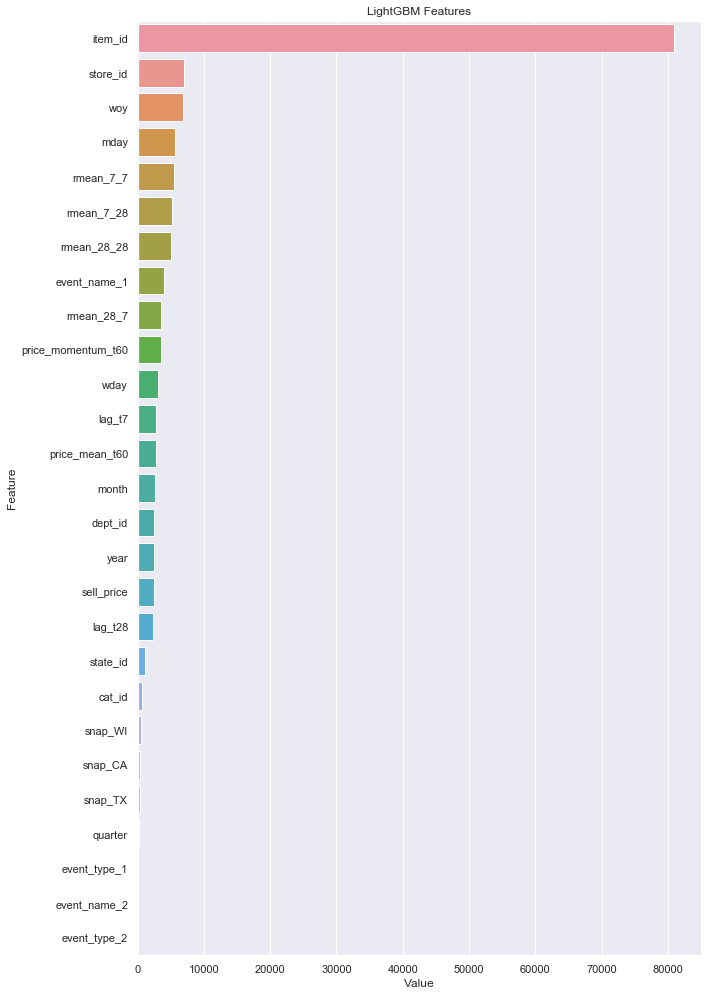

In [20]:
feature_importance = pd.DataFrame({"Value": m_lgb.feature_importance(), "Feature": m_lgb.feature_name()}) \
                    .sort_values(by="Value", ascending=False)

# Change size of the plot, so we can see all features
fig_dims = (10, 14)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x="Value", y="Feature", ax=ax, data=feature_importance)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [21]:
# Detection of features with zero-importance
zero_features = list(feature_importance[feature_importance['Value'] == 0]['Feature'])
print('\nThere are {} features with 0.0 importance'.format(len(zero_features)))
print(zero_features)
feature_importance


There are 0 features with 0.0 importance
[]


,Value,Feature
0,81007,item_id
2,6971,store_id
24,6873,woy
26,5657,mday
18,5473,rmean_7_7
20,5125,rmean_7_28
21,4968,rmean_28_28
8,3982,event_name_1
19,3522,rmean_28_7
23,3499,price_momentum_t60


In [22]:
%%time 

tdata = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data_test_model2.pkl')

CPU times: user 131 ms, sys: 104 ms, total: 236 ms
Wall time: 264 ms


In [94]:
def create_lag_features_for_test(df, day):
    # create lag feaures just for single day (faster)
    lags = [7, 28]
    lag_cols = [f"lag_t{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        df.loc[df.date == day, lag_col] = df.loc[df.date ==day-timedelta(days=lag), 'sales'].values  # !!! main

    windows = [7, 28]
    for window in windows:
        for lag in lags:
            df_window = df[(df.date <= day-timedelta(days=lag)) & (df.date > day-timedelta(days=lag+window))]
            df_window_grouped = df_window.groupby("id").agg({'sales':'mean'}).reindex(df.loc[df.date==day,'id'])
            df.loc[df.date == day,f"rmean_{lag}_{window}"] = df_window_grouped.sales.values     
    
    df['price_mean_t60'] = df.groupby(["id"])["sell_price"].transform(lambda x: x.rolling(60).mean()).astype(np.float16)
    df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)

    
## Creating features for test data
def create_date_features_for_test(df):
    # copy of the code from `create_df()` above
    date_features = {
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(
                df["date"].dt, date_feat_func).astype("int16")


In [55]:
create_date_features_for_test(tdata)

In [105]:
%%time

for i in range(0, 28):
    day = FIRST_PRED_DAY + timedelta(days=i)
    print(i, day)
    tst = tdata[(tdata.date >= day - timedelta(days=max_lags)) & (tdata.date <= day)].copy()
    create_lag_features_for_test(tst, day)
    tst = tst.loc[tst.date == day, train_cols]
    tdata.loc[tdata.date == day, "sales"] = 1.03*m_lgb.predict(tst) 


0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
CPU times: user 17min 33s, sys: 7.48 s, total: 17min 40s
Wall time: 9min 58s


In [106]:
os.system('say "Prediction complete"')

0

In [107]:
tdata.loc[(tdata.date >= FIRST_PRED_DAY) & (tdata.sales > 2)].count()

id              142711
item_id         142711
dept_id         142711
store_id        142711
cat_id          142711
state_id        142711
d               142711
sales           142711
date            142711
wm_yr_wk        142711
weekday         142711
wday            142711
month           142711
year            142711
event_name_1    142711
event_type_1    142711
event_name_2    142711
event_type_2    142711
snap_CA         142711
snap_TX         142711
snap_WI         142711
sell_price      142711
woy             142711
quarter         142711
mday            142711
dtype: int64

In [108]:
%%time

tdata_sub = tdata.loc[tdata.date >= FIRST_PRED_DAY, ["id", "sales"]].copy()
tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+ timedelta(days=h), "id"] = tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+timedelta(days=h), 
                                                                     "id"].str.replace("validation$", "evaluation")
tdata_sub["F"] = [f"F{rank}" for rank in tdata_sub.groupby("id")["id"].cumcount()+1]
tdata_sub = tdata_sub.set_index(["id", "F" ]).unstack()["sales"][[f"F{i}" for i in range(1,29)]].reset_index()
tdata_sub.fillna(0., inplace = True)

# kyakovlev magic trick
# for i in range(1,29):
#     tdata_sub['F'+str(i)] *= 1.03

tdata_sub.to_csv("submission.csv",index=False)
tdata_sub.shape


CPU times: user 3.67 s, sys: 137 ms, total: 3.8 s
Wall time: 3.9 s


(60980, 29)